### Synthetic Dataset

* Recreating Maggie's AAAI synthetic dataset
* Stochastic Block Model (SBM) -> use Networkx generator
* Maggie set her networks to size 500, with 0.5 and 0.01 within and across sub-community edge probabilities. 

Maggie's Generative Model
For every individual $i$:
1. For each neighbor $j \in n(i)$, draw the spreader state: $z_j \sim Bernoulli(\sigma(\boldsymbol{u}^T \boldsymbol{x_j} ))$
    * We are going to replace $z_j$ with the colonization pressure as calculated in the rolling risk model. CP $\in[0,1]$.
2. Draw the probability of exposure: $\theta_i|\boldsymbol{z_i} \sim Beta(1+\sum_{n(i)}z_j, 1+\sum_{n(i)}1-z_j)$
    * I visualized these resulting beta distributions and I wans't seeing the pattern we would expect: the more positive neighbors, the more right skewed the distribution. 
    * Simply combine using average
3. Draw exposure state: $\eta_i | \theta_i \sim Bernoulli(\theta_i)$


In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import os
from sklearn.metrics import roc_auc_score
from sklearn import linear_model
import torch
import pandas as pd
from sklearn.utils import resample
import difflib

from inprog166v22_jx import return_file_name, \
    format_data, new_location_codes, calc_CP, map_feature_names, \
    process_top_features, \
    auroc, preload_data, \
    graph_split, data_bundler, train_models, GCNa11

def emp_bootstrap_auc(y_true, y_pred, sample_auroc, n=1000, percentile=0.95):
    
    scores = []
    while True:
        try:
            _y_true, _y_pred = resample(y_true, y_pred)
            scores.append(roc_auc_score(_y_true, _y_pred))
        except:
            pass
        if len(scores)>=n:
            break
        
    deltas = scores - sample_auroc
    deltas.sort()
    ub_idx = int(n*((1-percentile)/2)) # "p.5"
    lb_idx = int(n*(percentile+(1-percentile)/2)) # "p.95" 
    return(sample_auroc - deltas[lb_idx], sample_auroc - deltas[ub_idx])

In [140]:
def get_comp_matrix(g, nclasses=2):
    '''
    g is networkx graph
    '''
    C = np.zeros((nclasses, nclasses))
    for e in g.edges():
        a = g.nodes[e[0]]['exposure'] or g.nodes[e[0]]['positive']
        b = g.nodes[e[1]]['exposure'] or g.nodes[e[1]]['positive']
        C[a][b] += 1
    return C

def hom_v1(C):
    '''
    C compatibility matrix from get_comp_matrix
    '''
    ret = [np.diag(C).sum() / C.sum()]
    for c in range(len(C)):
        ret.append(C[c][c] / (C[c].sum() + C[:, c].sum() - C[c][c]))
    return ret

def hom_v2(C):
    '''
    C compatibility matrix from get_comp_matrix
    '''
    C = C + C.transpose() # symmetric
    ret = [np.diag(C).sum() / C.sum()]
    for c in range(len(C)):
        ret.append(C[c][c] / C[c].sum())
    return ret

def calc_homophily(C, verbose=False):
    '''
    C compatibility matrix from get_comp_matrix
    '''
    ret = hom_v2(C)        
    if verbose:
        print(f'overall homophily ratio: {ret[0]:.2f}')
        for c in range(len(C)):
            print(f'class {c} homophily ratio: {ret[c+1]:.2f}')
        
g = nx.read_gpickle(os.path.join(gen_model_args['savepath'],'g0.pkl'))
C = get_comp_matrix(g)
calc_homophily(C, verbose=True)

overall homophily ratio: 0.63
class 0 homophily ratio: 0.70
class 1 homophily ratio: 0.53


In [141]:
def gen_network(args, verbose=False):
    
    # Network 
    edge_p = np.diag([args['in_p']-args['out_p']]*args['num_blocks']) 
    edge_p = edge_p + np.ones((args['num_blocks'],args['num_blocks']))*args['out_p']
    g = nx.stochastic_block_model(args['block_sizes'], edge_p)
    
    # Spreader State (aka CP)
    pos_nodes = np.random.choice(g.nodes, size=int(len(g.nodes)*args['pos_p']), replace=False)
    timesteps = np.random.choice(np.arange(args['max_pos_timestep']), size=len(pos_nodes))
    timesteps_norm = (-timesteps + args['max_pos_timestep'])/args['max_pos_timestep']
    symptomatic = np.random.binomial(1,args['symp_p'],size=len(pos_nodes))
    cp = 1-(np.minimum(timesteps,args['cp_decay']))*(1/args['cp_decay'])
    
    
    cp_decay_half = int(args['cp_decay']/2)
    cp_half = 1-(np.minimum(timesteps,cp_decay_half))*(1/cp_decay_half)

    attrs = {(i):{'positive':1 if i in pos_nodes else 0,
                  'days_since_pos': timesteps[np.where(pos_nodes==i)][0] if i in pos_nodes else np.nan,
                  'cp': cp[np.where(pos_nodes==i)][0] if i in pos_nodes else 0,
                  'cp_half': cp_half[np.where(pos_nodes==i)][0] if i in pos_nodes else 0,
                  'days_since_pos_norm': timesteps_norm[np.where(pos_nodes==i)][0] if i in pos_nodes else 0,
                  'symptomatic': symptomatic[np.where(pos_nodes==i)][0] if i in pos_nodes else 0}
             for i in range(len(g.nodes))}
    nx.set_node_attributes(g, attrs)
    
    # Exposure
    attrs = {}
    for i in g.nodes:
        
        neigh_cp_true = [nx.get_node_attributes(g,'cp')[j] for j in nx.all_neighbors(g,i) 
                    if nx.get_node_attributes(g,'symptomatic')[j]==1]
        neigh_cp = [nx.get_node_attributes(g,'cp')[j] for j in nx.all_neighbors(g,i)]
        neigh_cp_half = [nx.get_node_attributes(g,'cp_half')[j] for j in nx.all_neighbors(g,i)]
        
        if len(neigh_cp)>0:
            avg_cp = np.mean(neigh_cp)
            avg_cp_half = np.mean(neigh_cp_half)
        else: 
            avg_cp, avg_cp_half = 0, 0
            
        if len(neigh_cp_true)>0:
            true_cp = np.mean(neigh_cp_true)
        else:
            true_cp = 0

        exposure = np.random.binomial(1,true_cp)
        attrs[i] = {'avg_cp': avg_cp,
                    'avg_cp_half': avg_cp_half,
                    'true_cp': true_cp,
                    'exposure': exposure}
    nx.set_node_attributes(g, attrs)
    
    if verbose:
        print('Class Balance: {:.2f}'.format(np.mean([nx.get_node_attributes(g,'exposure')[i] for i in g.nodes])))
        C = get_comp_matrix(g)
        calc_homophily(C, verbose=verbose)
        
    return g

In [142]:
gen_model_args = {
    'num_blocks': 10,
    'in_p': 0.5,
    'out_p': 0.01,
    'pos_p': 0.2, # higher the more balanced
    'symp_p': 0.25,
    'max_pos_timestep': 30, # lower the more balanced
    'cp_decay': 14,
    'savepath': 'datapg', # 'data150v3-7'
    'num_datasets_train': 10, #1000, # make it lower to run faster
    'num_datasets_val': 20,
    'num_datasets_test': 20,
}
gen_model_args['num_datasets'] = gen_model_args['num_datasets_train'] + gen_model_args['num_datasets_val'] + gen_model_args['num_datasets_test']
gen_model_args['block_sizes'] = np.random.choice(np.arange(5,20), size=gen_model_args['num_blocks'])

In [178]:
import tqdm

# column = 'max_pos_timestep'
# xaxis = np.array([1, 5, 10, 15, 20, 25, 30])

column = 'pos_p'
xaxis = np.array([0, 0.1, 0.2, 0.4, 0.6, 0.8, 1.0])

# column = 'symp_p'
# xaxis = np.array([0.2, 0.4, 0.6, 0.8, 1.0])

orig = gen_model_args[column]
hom_overall = np.zeros_like(xaxis).astype(float)
hom_neg = np.zeros_like(xaxis).astype(float)
hom_pos = np.zeros_like(xaxis).astype(float)

repeat = 30
for _ in tqdm.trange(repeat):
    for i, x in enumerate(xaxis):
        gen_model_args[column] = x
                
        g = gen_network(gen_model_args)
        C = get_comp_matrix(g)
            
        a, b, c = hom_v2(C)
        hom_overall[i] += a
        if not np.isnan(b):
            hom_neg[i] += b
        if not np.isnan(c):
            hom_pos[i] += c

gen_model_args[column] = orig

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [01:45<00:00,  3.53s/it]


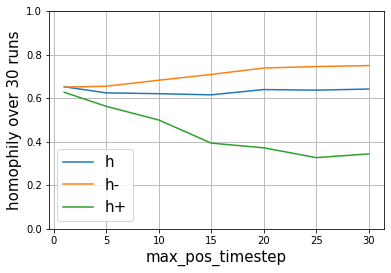

In [176]:
plt.plot(xaxis, hom_overall / repeat, label='h')
plt.plot(xaxis, hom_neg / repeat, label='h-')
plt.plot(xaxis, hom_pos / repeat, label='h+')
plt.legend(fontsize=15)
plt.xlabel(column, fontsize=15)
plt.ylabel(f'homophily over {repeat} runs', fontsize=15)
plt.grid()
plt.ylim(0,1)
plt.show()

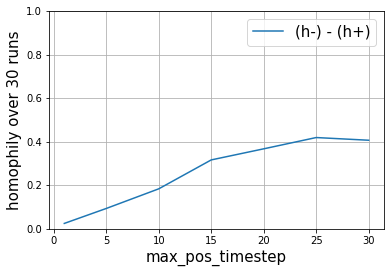

In [177]:
plt.plot(xaxis, (hom_neg - hom_pos) / repeat, label='(h-) - (h+)')
plt.legend(fontsize=15)
plt.xlabel(column, fontsize=15)
plt.ylabel(f'homophily over {repeat} runs', fontsize=15)
plt.grid()
plt.ylim(0,1)
plt.show()

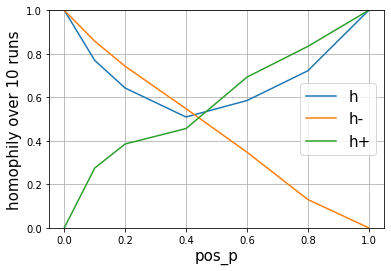

In [170]:
plt.plot(xaxis, hom_overall / repeat, label='h')
plt.plot(xaxis, hom_neg / repeat, label='h-')
plt.plot(xaxis, hom_pos / repeat, label='h+')
plt.legend(fontsize=15)
plt.xlabel(column, fontsize=15)
plt.ylabel(f'homophily over {repeat} runs', fontsize=15)
plt.grid()
plt.ylim(0,1)
plt.show()

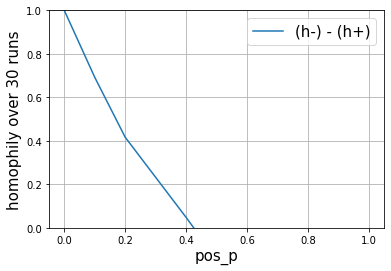

In [179]:
plt.plot(xaxis, (hom_neg - hom_pos) / repeat, label='(h-) - (h+)')
plt.legend(fontsize=15)
plt.xlabel(column, fontsize=15)
plt.ylabel(f'homophily over {repeat} runs', fontsize=15)
plt.grid()
plt.ylim(0,1)
plt.show()

# Visualization of attention

In [167]:
'''
TODO:
1. aggregate over layers
2. aggregate over multiple heads
3. aggregate over multiple test instances
4. aggregate over multiple nodes
'''
def calc_attention(query, key, value, mask=None, dropout=None, training=None):
    "Compute 'Scaled Dot Product Attention'"
    ## query/key/value: (bs, N, d)
    d_k = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)
    ## (bs, N, N) 

    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9) #(mask, value): fill with value where mask is true

    p_attn = F.softmax(scores, dim = -1)
    
    if dropout is not None:
        p_attn = F.dropout(p_attn, dropout, training)
        
    return torch.matmul(p_attn, value), p_attn

def attention_viz(runpath):
    
    # Load args
    args = np.load(runpath+'args.npy',allow_pickle=True).item()
    
    # Load Model
    model = args['GCN'](args).cuda()
    model.load_state_dict(torch.load(runpath+'.pth.tar'))
    model.eval()

    # Load Test Data
    S, target, A, pop, gid = preload_data(args,np.arange(args['num_datasets']-args['num_datasets_test'], args['num_datasets']))  
    
    # For each network in Test
    yhat_y = {'yhat':[], 'y':[]}
    for S_, target_, A_, pop_, gid_ in zip(S, target, A, pop, gid):

        # -- Save yhat & y
        yhat_, y_= auroc(args, model, S_, target_, A_, pop_, gid_)
        yhat_y['y'].append(y_)
        yhat_y['yhat'].append(yhat_)

    # Calculate AUROC to match LogReg's Calculation (Over all datasets)
    yhat_y['yhat'] = np.concatenate(yhat_y['yhat'], axis=0)
    yhat_y['y'] = np.concatenate(yhat_y['y'], axis=0)
    yhat_y['auroc'] = roc_auc_score(yhat_y['y'], yhat_y['yhat'])

    # Calculate empirical bootstrap of the auc
    return yhat_y['auroc'], emp_bootstrap_auc(yhat_y['y'], yhat_y['yhat'], yhat_y['auroc'])


runpath = '/data4/jeeheh/ShadowPeriod/Toy2/results/' + 'inprog166v22_jxGATd=1_data150jx'
a, (b,c) = attention_viz(runpath)
print('{:.3f} ({:.3f},{:.3f})'.format(a,b,c))

0.883 (0.852,0.915)
